In [90]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
from model import Generator, Discriminator
from Utils import weights_init, read_raw, generateBatches

import sys
sys.path = ['/home/arseniy/Desktop/SimonSays/MnistGAN'] + sys.path

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
ngpu = 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

Random Seed:  999
cuda:0


In [91]:
# Root directory for dataset
dataroot = "/home/arseniy/Desktop/SimonSays/MnistGAN/celebra"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 5

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 25

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [92]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [93]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [94]:


# images1 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/5479_28_28_500.raw", volume_size=28)
images = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/5548_64_64_500.raw", volume_size=64)
images = images[212:257]
# images3 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/9005_28_28_500.raw", volume_size=28)
# images4 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/15581_28_28_500.raw", volume_size=28)
# images5 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/15588_28_28_500.raw", volume_size=28)
# images6 = read_raw("/home/arseniy/Desktop/DataImages/GANTESTING/15604_28_28_500.raw", volume_size=28)
# images = np.concatenate((images1, images2, images3, images4, images5, images6), axis=0)

print("shape ", images.shape)

batch_size = 10
num_train = images.shape[0]
num_epochs = 600

batches_indices = generateBatches(batch_size, num_train)

shape  (45, 1, 64, 64)


In [95]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr)
optimizerG = optim.Adam(netG.parameters(), lr=lr)

# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
images = images.astype(np.float32)
imgs = torch.tensor(images)
torch.manual_seed(777)
np.random.seed(777)

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    batches_indices = generateBatches(batch_size, len(imgs))
    i=-1
    for batch_indices in batches_indices:
        i+=1
        batch_imgs = imgs[batch_indices]

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = batch_imgs.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        # if i % 50 == 0:
        #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        #           % (epoch, num_epochs, i, len(imgs),
        #              errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())


Starting Training Loop...


shape torch.Size([5, 100, 1, 1])


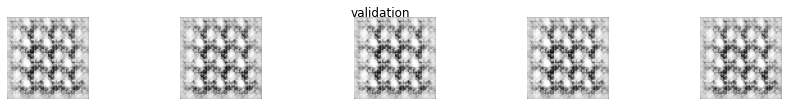

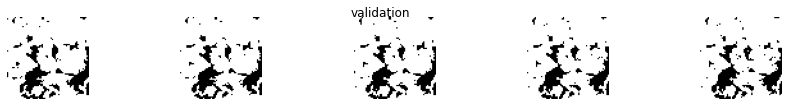

In [97]:
noise = torch.randn(b_size, nz, 1, 1, device=device)
print("shape", noise.shape)
noise = noise.to(device)
fake = netG(noise)
# print("fake inputs ", fake_inputs)


number = 5
fig = plt.figure(figsize=(15,1.5))
fig.suptitle("validation")
for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')


        torch.manual_seed(i)
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        noise = noise.to(device)
        fake = netG(noise)
        plt.imshow(fake[i].permute(1, 2, 0).detach().cpu(), cmap='gray')


real_images = images.reshape(images.shape[0], images.shape[2], images.shape[3])
fig = plt.figure(figsize=(15,1.5))
fig.suptitle("validation")
for i in range(number):
        plt.subplot(1,number, i+1)
        plt.axis('off')
        # plt.imshow(fake_inputs[i].permute(1, 2, 0).detach().cpu(), cmap='gray')
        plt.imshow(real_images[i], cmap='gray')



# plt.imshow(images[i].permute(1, 2, 0).detach().cpu())